# Consumption Data using Long-Short-Term Memory model #
 https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM


In [1]:
import pandas as pd
import numpy as np
import os

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import permutations

from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf

import statsmodels.graphics.tsaplots as tsaplot
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing, SimpleExpSmoothing

import tensorflow as tf

from tensorflow import keras

from tensorflow.keras.layers import *
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

import keras 
from keras.models import Sequential # intitialize the ANN
from keras.layers import Dense, Activation, Dropout, LSTM     # create layers


np.random.seed(42)
tf.random.set_seed(42)


We will start with the test train split 
in our case we can create several shorter sequences that we will use to train our model with 


In [2]:
df = pd.read_pickle("../data/final_dataframe.pkl")

In [3]:
def col_names(df):
    column_names = {'Photovoltaics [MWh] Original resolutions': 'Solar_generation_MWh',
                'Photovoltaics [MW] Calculated resolutions': 'Solar_installed_MW',
                'Total (grid load) [MWh] Original resolutions': 'Total_consumption_MWh',
                'Germany/Luxembourg [€/MWh] Calculated resolutions': 'DE_LU_price_per_MWh',}
    df.rename(columns=column_names, inplace=True)


In [4]:
col_names(df)

In [5]:
df.set_index('Date')


,Solar_generation_MWh,Solar_installed_MW,Total_consumption_MWh,DE_LU_price_per_MWh,normalisation_factor,Solar_generation_MWh_normalized
Date,,,,,,
2018-10-01 00:00:00,0.0,42805.0,10589.75,59.53,0.684015,0.0
2018-10-01 00:15:00,0.0,42805.0,10589.75,59.53,0.684015,0.0
2018-10-01 00:30:00,0.0,42805.0,10589.75,59.53,0.684015,0.0
2018-10-01 00:45:00,0.0,42805.0,10589.75,59.53,0.684015,0.0
2018-10-01 01:00:00,0.0,42805.0,10589.75,56.10,0.684015,0.0
...,...,...,...,...,...,...
2023-06-01 22:45:00,0.0,62579.0,12945.50,95.41,1.000000,0.0
2023-06-01 23:00:00,0.0,62579.0,12817.75,86.53,1.000000,0.0
2023-06-01 23:15:00,0.0,62579.0,12539.00,86.53,1.000000,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163680 entries, 0 to 163679
Data columns (total 7 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   Date                             163680 non-null  datetime64[ns]
 1   Solar_generation_MWh             163680 non-null  float64       
 2   Solar_installed_MW               163680 non-null  float64       
 3   Total_consumption_MWh            163680 non-null  float64       
 4   DE_LU_price_per_MWh              163680 non-null  float64       
 5   normalisation_factor             163680 non-null  float64       
 6   Solar_generation_MWh_normalized  163680 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 8.7 MB


## Scaling is very important. Here after trying both standard and MinMax scaler, MinMax scaler is better.

In [7]:
#Let's scale the data

from sklearn.preprocessing import MinMaxScaler
# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Scale the 'Total_consumption_MWh' column
df['Total_consumption_MWh'] = scaler.fit_transform(df[['Total_consumption_MWh']])


<Axes: xlabel='Date'>

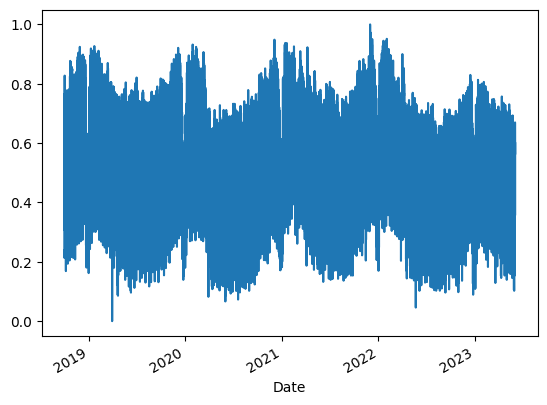

In [8]:
df.index = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S')
consumption = df['Total_consumption_MWh']
consumption.plot()

In [9]:
# functions for generating input-output pairs X1 and y1 respectively
# Iterate through the array to create input-output pairs:
# The loop iterates from i = 0 to i = len(df_as_np) - window_size - forecast_size + 1.
# At each iteration, it extracts the input sequence (X_row) of length window_size and the corresponding output sequence (y_row) of length forecast_size.
# Append the input sequence X_row to the X list and the output sequence y_row to the y list.

def df_to_X_y(df, window_size=672, forecast_size=96):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size - forecast_size + 1):
        X_row = df_as_np[i : i + window_size]
        y_row = df_as_np[i + window_size : i + window_size + forecast_size]
        X.append(X_row)
        y.append(y_row)
    return np.array(X), np.array(y)

WINDOW_SIZE = 672
FORECAST_SIZE = 96
X1, y1 = df_to_X_y(consumption, window_size=WINDOW_SIZE, forecast_size=FORECAST_SIZE)
print("X1 shape:", X1.shape)
print("y1 shape:", y1.shape)



X1 shape: (162913, 672)
y1 shape: (162913, 96)


In [10]:
X1

array([[0.23859159, 0.23859159, 0.23859159, ..., 0.30646827, 0.29068967,
        0.28267605],
       [0.23859159, 0.23859159, 0.23859159, ..., 0.29068967, 0.28267605,
        0.27766515],
       [0.23859159, 0.23859159, 0.23859159, ..., 0.28267605, 0.27766515,
        0.27240562],
       ...,
       [0.3305665 , 0.31891902, 0.30206939, ..., 0.41328463, 0.39211261,
        0.37935585],
       [0.31891902, 0.30206939, 0.29070879, ..., 0.39211261, 0.37935585,
        0.36388326],
       [0.30206939, 0.29070879, 0.2784493 , ..., 0.37935585, 0.36388326,
        0.35604177]])

In [11]:
y1

array([[0.27766515, 0.27240562, 0.26186742, ..., 0.41630647, 0.40104426,
        0.37547336],
       [0.27240562, 0.26186742, 0.25567073, ..., 0.40104426, 0.37547336,
        0.36833952],
       [0.26186742, 0.25567073, 0.24475003, ..., 0.37547336, 0.36833952,
        0.3568833 ],
       ...,
       [0.36388326, 0.35604177, 0.34638335, ..., 0.41881192, 0.40903875,
        0.38771373],
       [0.35604177, 0.34638335, 0.33771947, ..., 0.40903875, 0.38771373,
        0.37486134],
       [0.34638335, 0.33771947, 0.32957197, ..., 0.38771373, 0.37486134,
        0.36000077]])

## Splitting

In [20]:
# Splitting the data into train, validation, and test sets
#implementing 70-15-15 rule, where 70% of the data is used for training, 15% for validation, and 15% for testing.

total_samples = len(X1)
train_size = int(0.7 * total_samples)
val_size = int(0.15 * total_samples)

X_train1, y_train1 = X1[:train_size], y1[:train_size]
X_val1, y_val1 = X1[train_size:train_size+val_size], y1[train_size:train_size+val_size]
X_test1, y_test1 = X1[train_size+val_size:], y1[train_size+val_size:]

X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

# Check for NaN values in the data
# print("NaN values in X_train1:", np.isnan(X_train1).any())
# print("NaN values in y_train1:", np.isnan(y_train1).any())




((114039, 672),
 (114039, 96),
 (24436, 672),
 (24436, 96),
 (24438, 672),
 (24438, 96))

In [22]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

# Define your model architecture
model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.LSTM(64, input_shape=(WINDOW_SIZE, 1), return_sequences=True))
#model1.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model1.add(tf.keras.layers.LSTM(32, activation='relu'))
model1.add(tf.keras.layers.Dropout(0.2))  # Add dropout layer with a dropout rate of 0.2
model1.add(tf.keras.layers.Dense(16, activation='relu'))
model1.add(tf.keras.layers.Dense(FORECAST_SIZE, activation='linear'))

# Build the model
model1.build((None, WINDOW_SIZE, 1))
model1.summary()

# Define optimizer used for modeling and checkpoint
cp1 = tf.keras.callbacks.ModelCheckpoint('model1/', save_best_only=True)  # It will save the best result only

learning_rate = 0.00001  # Adjust the learning rate if needed

# Compile the model
model1.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate), metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Enable hardware acceleration (if available)
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Train the model with batch processing
batch_size = 64
history = model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, batch_size=batch_size, callbacks=[cp1, early_stopping])

# Print the training history
print(history.history)

# Load the saved model
model1 = tf.keras.models.load_model('model1/')

# Reshape the data for prediction
X_train_reshaped = np.reshape(X_train1, (X_train1.shape[0], WINDOW_SIZE, 1))

# Predict on training data
train_predictions = model1.predict(X_train_reshaped).flatten().reshape(-1, 1)
train_results = pd.DataFrame(data={'Train Predictions': train_predictions.flatten(), 'Actuals': y_train1.flatten()})
train_results


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 672, 64)           16896     
                                                                 
 lstm_11 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 96)                1632      
                                                                 
Total params: 31472 (122.94 KB)
Trainable params: 31472 (122.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
1782/

INFO:tensorflow:Assets written to: model1/assets


1782/1782 [==============================] - 628s 352ms/step - loss: 0.2352 - root_mean_squared_error: 0.4849 - val_loss: 0.1332 - val_root_mean_squared_error: 0.3649
Epoch 2/10
1782/1782 [==============================] - ETA: 0s - loss: 0.1191 - root_mean_squared_error: 0.3451INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1782/1782 [==============================] - 622s 349ms/step - loss: 0.1191 - root_mean_squared_error: 0.3451 - val_loss: 0.0589 - val_root_mean_squared_error: 0.2426
Epoch 3/10
1782/1782 [==============================] - ETA: 0s - loss: 0.0677 - root_mean_squared_error: 0.2602INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1782/1782 [==============================] - 681s 382ms/step - loss: 0.0677 - root_mean_squared_error: 0.2602 - val_loss: 0.0346 - val_root_mean_squared_error: 0.1860
Epoch 4/10
1782/1782 [==============================] - ETA: 0s - loss: 0.0494 - root_mean_squared_error: 0.2223INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1782/1782 [==============================] - 789s 443ms/step - loss: 0.0494 - root_mean_squared_error: 0.2223 - val_loss: 0.0292 - val_root_mean_squared_error: 0.1708
Epoch 5/10
1782/1782 [==============================] - ETA: 0s - loss: 0.0419 - root_mean_squared_error: 0.2048INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1782/1782 [==============================] - 637s 358ms/step - loss: 0.0419 - root_mean_squared_error: 0.2048 - val_loss: 0.0273 - val_root_mean_squared_error: 0.1651
Epoch 6/10
1782/1782 [==============================] - ETA: 0s - loss: 0.0378 - root_mean_squared_error: 0.1945INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1782/1782 [==============================] - 636s 357ms/step - loss: 0.0378 - root_mean_squared_error: 0.1945 - val_loss: 0.0266 - val_root_mean_squared_error: 0.1631
Epoch 7/10
1782/1782 [==============================] - ETA: 0s - loss: 0.0352 - root_mean_squared_error: 0.1876INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1782/1782 [==============================] - 634s 356ms/step - loss: 0.0352 - root_mean_squared_error: 0.1876 - val_loss: 0.0254 - val_root_mean_squared_error: 0.1594
Epoch 8/10
1782/1782 [==============================] - ETA: 0s - loss: 0.0316 - root_mean_squared_error: 0.1779INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1782/1782 [==============================] - 624s 350ms/step - loss: 0.0316 - root_mean_squared_error: 0.1779 - val_loss: 0.0222 - val_root_mean_squared_error: 0.1491
Epoch 9/10
1782/1782 [==============================] - ETA: 0s - loss: 0.0281 - root_mean_squared_error: 0.1675INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1782/1782 [==============================] - 628s 352ms/step - loss: 0.0281 - root_mean_squared_error: 0.1675 - val_loss: 0.0198 - val_root_mean_squared_error: 0.1406
Epoch 10/10
1782/1782 [==============================] - ETA: 0s - loss: 0.0252 - root_mean_squared_error: 0.1586INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1782/1782 [==============================] - 622s 349ms/step - loss: 0.0252 - root_mean_squared_error: 0.1586 - val_loss: 0.0174 - val_root_mean_squared_error: 0.1319
{'loss': [0.23516525328159332, 0.11909586191177368, 0.06769595295190811, 0.04942367225885391, 0.041926030069589615, 0.03784674406051636, 0.0352073535323143, 0.03163274750113487, 0.02805609628558159, 0.025159155949950218], 'root_mean_squared_error': [0.484937846660614, 0.3451029360294342, 0.26018446683883667, 0.22231435775756836, 0.20475837588310242, 0.19454249739646912, 0.1876363754272461, 0.17785599827766418, 0.16749966144561768, 0.15861648321151733], 'val_loss': [0.13318416476249695, 0.05885649472475052, 0.03459526225924492, 0.029169214889407158, 0.02726813778281212, 0.026604516431689262, 0.025415068492293358, 0.022232385352253914, 0.01977233961224556, 0.017401155084371567], 'val_root_mean_squared_error': [0.36494413018226624, 0.24260364472866058, 0.18599805235862732, 0.17078998684883118, 0.1651306450366974, 0.163108929

,Train Predictions,Actuals
0,0.376197,0.277665
1,0.376928,0.272406
2,0.358184,0.261867
3,0.399478,0.255671
4,0.385250,0.244750
...,...,...
10947739,0.640905,0.688483
10947740,0.667506,0.678729
10947741,0.665924,0.668152
10947742,0.729458,0.651608


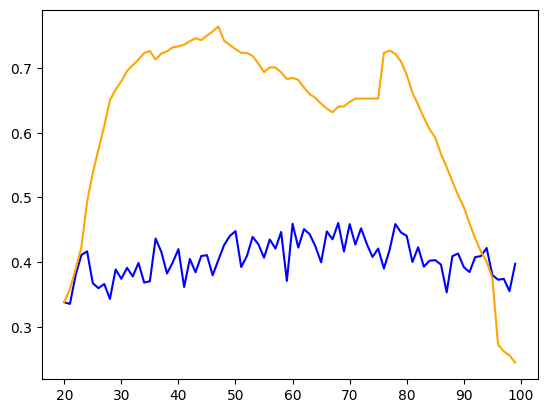

In [31]:
#plottings
plt.plot(train_results['Train Predictions'][20:100], color='blue', label='Prediction')
plt.plot(train_results['Actuals'][20:100], color='orange', label='Actual')

### OMG! the far far away from or close to actual. let's see how it works for validation and testing..

In [54]:
# Reshape the data for prediction
X_val_reshaped = np.reshape(X_val1, (X_val1.shape[0], WINDOW_SIZE, 1))

# Predict on validation data
val_predictions = model1.predict(X_val_reshaped).flatten()
val_results = pd.DataFrame(data={'Val Predictions': val_predictions, 'Actuals': y_val1.flatten()})
val_results


764/764 [==============================] - 37s 48ms/step


,Val Predictions,Actuals
0,0.657197,0.650021
1,0.657053,0.637609
2,0.634048,0.626210
3,0.634959,0.608136
4,0.705787,0.591382
...,...,...
2345851,0.502210,0.603833
2345852,0.508546,0.606262
2345853,0.511849,0.609972
2345854,0.549843,0.607945


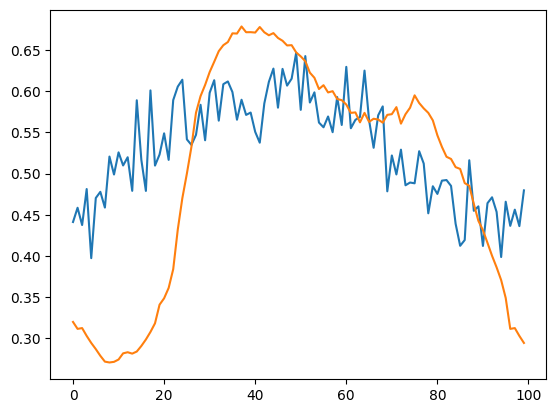

In [33]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])


In [35]:
# Reshape the data for prediction
X_test_reshaped = np.reshape(X_test1, (X_test1.shape[0], WINDOW_SIZE, 1))
#predict on test data
test_predictions = model1.predict(X_test_reshaped).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1.flatten()})
test_results

764/764 [==============================] - 37s 48ms/step


,Test Predictions,Actuals
0,0.550394,0.648453
1,0.516111,0.654286
2,0.541220,0.661439
3,0.517438,0.664843
4,0.574610,0.663046
...,...,...
2346043,0.458865,0.418812
2346044,0.451981,0.409039
2346045,0.454777,0.387714
2346046,0.412288,0.374861


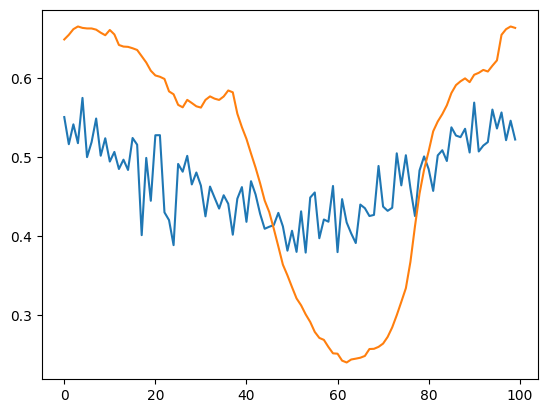

In [36]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])


### After observing all train, validation and test we can say, as a first model it's not that good and not that bad. Let's see how it goes for the next few models.

In [69]:
X_test1.shape

(24438, 672)

In [70]:
y_test1.shape

(24438, 96)

764/764 [==============================] - 37s 49ms/step


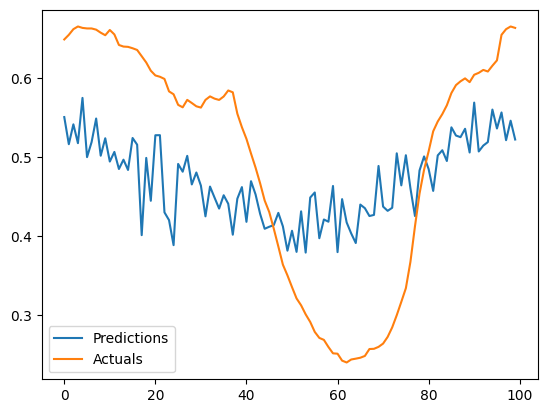

(         Predictions   Actuals
 0           0.550394  0.648453
 1           0.516111  0.654286
 2           0.541220  0.661439
 3           0.517438  0.664843
 4           0.574610  0.663046
 ...              ...       ...
 2346043     0.458865  0.418812
 2346044     0.451981  0.409039
 2346045     0.454777  0.387714
 2346046     0.412288  0.374861
 2346047     0.434172  0.360001
 
 [2346048 rows x 2 columns],
 0.012732544160074813)

In [72]:
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt

def plot_predictions1(model1, X, y, start=0, end=100):
    X_reshaped = X.reshape((X.shape[0], 672, 1))
    predictions = model1.predict(X_reshaped)
    predictions = predictions.reshape((-1, predictions.shape[1]))
    df = pd.DataFrame(data={'Predictions': predictions.flatten(), 'Actuals': y.flatten()})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    plt.legend(['Predictions', 'Actuals'])
    plt.show()
    return df, mse(y[start:end], predictions[start:end])
plot_predictions1(model1, X_test1, y_test1)

In [75]:
model2 = Sequential()
model2.add(InputLayer((672, 1)))
model2.add(Conv1D(64, kernel_size=2))
model2.add(Flatten())
model2.add(Dense(16, 'relu'))
model2.add(Dense(96, 'linear'))

model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 671, 64)           192       
                                                                 
 flatten (Flatten)           (None, 42944)             0         
                                                                 
 dense_12 (Dense)            (None, 16)                687120    
                                                                 
 dense_13 (Dense)            (None, 96)                1632      
                                                                 
Total params: 688944 (2.63 MB)
Trainable params: 688944 (2.63 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [76]:
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()]) ## due to a warning message I used the legacy.Adam
# Train the model
history = model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp2])

# Print the training history
print(history.history)

Epoch 1/10
3553/3564 [============================>.] - ETA: 0s - loss: 0.0516 - root_mean_squared_error: 0.2271INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


3564/3564 [==============================] - 15s 4ms/step - loss: 0.0515 - root_mean_squared_error: 0.2268 - val_loss: 0.0165 - val_root_mean_squared_error: 0.1286
Epoch 2/10
3556/3564 [============================>.] - ETA: 0s - loss: 0.0137 - root_mean_squared_error: 0.1172INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


3564/3564 [==============================] - 14s 4ms/step - loss: 0.0137 - root_mean_squared_error: 0.1171 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0836
Epoch 3/10
3561/3564 [============================>.] - ETA: 0s - loss: 0.0066 - root_mean_squared_error: 0.0813INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


3564/3564 [==============================] - 14s 4ms/step - loss: 0.0066 - root_mean_squared_error: 0.0813 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0716
Epoch 4/10
3562/3564 [============================>.] - ETA: 0s - loss: 0.0059 - root_mean_squared_error: 0.0768INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


3564/3564 [==============================] - 14s 4ms/step - loss: 0.0059 - root_mean_squared_error: 0.0768 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0698
Epoch 5/10
3558/3564 [============================>.] - ETA: 0s - loss: 0.0055 - root_mean_squared_error: 0.0743INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


3564/3564 [==============================] - 13s 4ms/step - loss: 0.0055 - root_mean_squared_error: 0.0743 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0670
Epoch 6/10
3558/3564 [============================>.] - ETA: 0s - loss: 0.0051 - root_mean_squared_error: 0.0712INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


3564/3564 [==============================] - 14s 4ms/step - loss: 0.0051 - root_mean_squared_error: 0.0712 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0640
Epoch 7/10
3550/3564 [============================>.] - ETA: 0s - loss: 0.0047 - root_mean_squared_error: 0.0688INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


3564/3564 [==============================] - 14s 4ms/step - loss: 0.0047 - root_mean_squared_error: 0.0688 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0621
Epoch 8/10
3552/3564 [============================>.] - ETA: 0s - loss: 0.0046 - root_mean_squared_error: 0.0678INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


3564/3564 [==============================] - 14s 4ms/step - loss: 0.0046 - root_mean_squared_error: 0.0678 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0609
Epoch 9/10
3564/3564 [==============================] - 14s 4ms/step - loss: 0.0045 - root_mean_squared_error: 0.0673 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0612
Epoch 10/10
3564/3564 [==============================] - 14s 4ms/step - loss: 0.0045 - root_mean_squared_error: 0.0671 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0610
{'loss': [0.05145720764994621, 0.013712750747799873, 0.006602420937269926, 0.005892960820347071, 0.005514700431376696, 0.005075475666671991, 0.00473396759480238, 0.0045930007472634315, 0.004529294092208147, 0.0045050871558487415], 'root_mean_squared_error': [0.2268417328596115, 0.11710145324468613, 0.08125525712966919, 0.07676560431718826, 0.07426100224256516, 0.07124241441488266, 0.06880378723144531, 0.06777162849903107, 0.06730004400014877, 0.06711988151073456], 'val_loss': [0.0

In [80]:
model3 = Sequential()
model3.add(InputLayer((672, 1)))
model3.add(GRU(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(96, 'linear'))
model3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 64)                12864     
                                                                 
 dense_16 (Dense)            (None, 8)                 520       
                                                                 
 dense_17 (Dense)            (None, 96)                864       
                                                                 
Total params: 14248 (55.66 KB)
Trainable params: 14248 (55.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [81]:
cp3 = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [82]:
model3.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp3])

Epoch 1/10
3564/3564 [==============================] - ETA: 0s - loss: 0.0770 - root_mean_squared_error: 0.2774INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


3564/3564 [==============================] - 379s 106ms/step - loss: 0.0770 - root_mean_squared_error: 0.2774 - val_loss: 0.0206 - val_root_mean_squared_error: 0.1434
Epoch 2/10
3564/3564 [==============================] - ETA: 0s - loss: 0.0146 - root_mean_squared_error: 0.1209INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


3564/3564 [==============================] - 376s 106ms/step - loss: 0.0146 - root_mean_squared_error: 0.1209 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0954
Epoch 3/10
3564/3564 [==============================] - ETA: 0s - loss: 0.0083 - root_mean_squared_error: 0.0912INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


3564/3564 [==============================] - 396s 111ms/step - loss: 0.0083 - root_mean_squared_error: 0.0912 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0835
Epoch 4/10
3564/3564 [==============================] - ETA: 0s - loss: 0.0071 - root_mean_squared_error: 0.0844INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


3564/3564 [==============================] - 396s 111ms/step - loss: 0.0071 - root_mean_squared_error: 0.0844 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0784
Epoch 5/10
3564/3564 [==============================] - ETA: 0s - loss: 0.0066 - root_mean_squared_error: 0.0810INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


3564/3564 [==============================] - 380s 107ms/step - loss: 0.0066 - root_mean_squared_error: 0.0810 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0764
Epoch 6/10
3564/3564 [==============================] - ETA: 0s - loss: 0.0062 - root_mean_squared_error: 0.0789INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


3564/3564 [==============================] - 382s 107ms/step - loss: 0.0062 - root_mean_squared_error: 0.0789 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0745
Epoch 7/10
3564/3564 [==============================] - ETA: 0s - loss: 0.0059 - root_mean_squared_error: 0.0768INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


3564/3564 [==============================] - 382s 107ms/step - loss: 0.0059 - root_mean_squared_error: 0.0768 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0741
Epoch 8/10
3564/3564 [==============================] - ETA: 0s - loss: 0.0056 - root_mean_squared_error: 0.0746INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


3564/3564 [==============================] - 400s 112ms/step - loss: 0.0056 - root_mean_squared_error: 0.0746 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0706
Epoch 9/10
3564/3564 [==============================] - ETA: 0s - loss: 0.0051 - root_mean_squared_error: 0.0715INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


3564/3564 [==============================] - 418s 117ms/step - loss: 0.0051 - root_mean_squared_error: 0.0715 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0674
Epoch 10/10
3564/3564 [==============================] - ETA: 0s - loss: 0.0047 - root_mean_squared_error: 0.0683INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


3564/3564 [==============================] - 434s 122ms/step - loss: 0.0047 - root_mean_squared_error: 0.0683 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0641


In [83]:
consumption_df = pd.DataFrame({'Consumption' : consumption})
consumption_df['Seconds'] = consumption_df.index.map(pd.Timestamp.timestamp)
consumption_df

,Consumption,Seconds
Date,,
2018-10-01 00:00:00,0.238592,1.538352e+09
2018-10-01 00:15:00,0.238592,1.538353e+09
2018-10-01 00:30:00,0.238592,1.538354e+09
2018-10-01 00:45:00,0.238592,1.538355e+09
2018-10-01 01:00:00,0.238592,1.538356e+09
...,...,...
2023-06-01 22:45:00,0.418812,1.685660e+09
2023-06-01 23:00:00,0.409039,1.685660e+09
2023-06-01 23:15:00,0.387714,1.685661e+09


In [84]:
day = 60*60*24
year = 365.2425*day

consumption_df['Day sin'] = np.sin(consumption_df['Seconds'] * (2* np.pi / day))
consumption_df['Day cos'] = np.cos(consumption_df['Seconds'] * (2 * np.pi / day))
consumption_df['Year sin'] = np.sin(consumption_df['Seconds'] * (2 * np.pi / year))
consumption_df['Year cos'] = np.cos(consumption_df['Seconds'] * (2 * np.pi / year))
consumption_df.head()

,Consumption,Seconds,Day sin,Day cos,Year sin,Year cos
Date,,,,,,
2018-10-01 00:00:00,0.238592,1.538352e+09,-7.593937e-12,1.000000,-0.999952,-0.009838
2018-10-01 00:15:00,0.238592,1.538353e+09,6.540313e-02,0.997859,-0.999953,-0.009658
2018-10-01 00:30:00,0.238592,1.538354e+09,1.305262e-01,0.991445,-0.999955,-0.009479
2018-10-01 00:45:00,0.238592,1.538355e+09,1.950903e-01,0.980785,-0.999957,-0.009300
2018-10-01 01:00:00,0.238592,1.538356e+09,2.588190e-01,0.965926,-0.999958,-0.009121
